#**Step 1: Install All the Required Packages**

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires transformers>=4.33.1, but you have transformers 4.31.0 which is incompatible.


#**Step 2: Import All the Required Libraries**

In [2]:
import os
import torch
import pandas as pd
import json
import warnings
from datasets import load_dataset
from datasets import load_from_disk
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
from tqdm.notebook import tqdm
from huggingface_hub import interpreter_login

2024-04-28 06:20:42.884908: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 06:20:42.885006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 06:20:43.002443: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#**In case of LLMs , the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

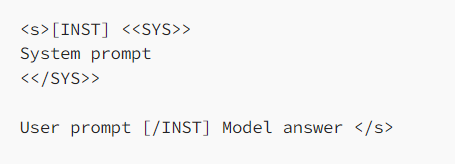

We have borrowed a formatted Medquad dataset for the same purpose. It was already hosted on HuggingFace in this specific format


Dataset : https://huggingface.co/datasets/Tonic/medquad

#**How to fine tune LLMs with Peft and Lora**

- Free KAGGLE offers a 15GB Graphics Card (Limited Resources --> Barely enough to store most LLM’s weights (Even if we take an average of 1 Billion weights in most LLMs)

- We also need to consider the overhead due to optimizer states, gradients, and forward activations

- Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.

- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

#**Step 3**

1. Load a LLM model (chat model)
    Here we can supplpy different model names in the model_name parameter if they are hosted on Hugging Face to load them
2. Train it on the MedQuad dataset  which will produce our fine-tuned model 

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the LLM model directly in 4-bit precision using the NF4 type and train it for 3 epochs

In [3]:
# The model that you want to train from the Hugging Face hub
model_name = "gpt2"

# # The instruction dataset to use
# dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "gpt2-finetune17k"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 3

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the LLM model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [4]:

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# dataset = load_dataset("json", data_files="/content/data.json", field='json', split="train")
# dataset = dataset.map(generate_and_tokenize_prompt)
# dataset = dataset.remove_columns(column_names=['text','label'])
dataset = load_dataset("Tonic/medquad", split="train")

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15549 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/15549 [00:00<?, ? examples/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,3.416000
50,3.625200
75,3.381300
100,3.421700
125,3.157400
150,3.148900
175,2.718500
200,2.633300
225,2.359100
250,2.273800


TrainOutput(global_step=11664, training_loss=1.4667870687686204, metrics={'train_runtime': 1335.0954, 'train_samples_per_second': 34.939, 'train_steps_per_second': 8.736, 'total_flos': 1494139766086656.0, 'train_loss': 1.4667870687686204, 'epoch': 3.0})

In [5]:
# Save trained model
trainer.model.save_pretrained(new_model)

##**Step 5: Check the plots on tensorboard, as follows**

###**Step 6:Use the text generation pipeline to ask questions like “What is a large language model?” Note that I’m formatting the input to match Llama 2 prompt template.**

In [6]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "What are the treatments for Gastrointestinal Carcinoid Tumors?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<s>[INST] What are the treatments for Gastrointestinal Carcinoid Tumors? [/INST]
[INST] What are the treatments for Gastropathy of Gastrointestinal Carcinoid Tumors? [/INST] 
                An emergency is a delay- and sometimes critical surgery. Some drugs are already used to slow or even reverse the metabolism of a particular body part. These medications are usually taken daily. Medications are sometimes withdrawn. Other medications usually be added to treat gastric tumors.
                
To help manage abdominal pain, pain, and other problems, the most common course of medical treatment in a patient with an abscess is to relieve pressure on the stomach. Patients often experience some side effects within six months or even three months after giving the treatment.     
   


In [7]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

0

You can train a Llama 2 model on the entire dataset using [mlabonne/guanaco-llama2](https://huggingface.co/datasets/mlabonne/guanaco-llama2)

#**Step 7: Store New LLM Model (Llama-2-7b-chat-finetune)**

How can we store our new LLM finetuned model now? We need to merge the weights from LoRA with the base model. Unfortunately, as far as we explored, we need to reload the base model in FP16 precision and use the peft library to merge everything.

In [8]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

/opt/conda/lib/python3.10/site-packages/peft/tuners/lora.py:299: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


#**Step 8: Push Model to Hugging Face Hub**

Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.

In [9]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [10]:
from huggingface_hub import login
login()
"Here --> Login Token Write from hugging face"

'Here --> Login Token Write from hugging face'

In [12]:
model.push_to_hub("Sidsky08/gpt2-finetune17k", check_pr=True)
tokenizer.push_to_hub("Sidsky08/gpt2-finetune17k",check_pr=True)


pytorch_model.bin:   0%|          | 0.00/249M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Sidsky08/gpt2-finetune17k/commit/f1494b7ee07415a8da35b44e936e7d79f51d9c85', commit_message='Upload tokenizer', commit_description='', oid='f1494b7ee07415a8da35b44e936e7d79f51d9c85', pr_url=None, pr_revision=None, pr_num=None)

You can now use this model for inference by loading it like any other Llama 2 model from the Hub.

In [ ]:
pip install --upgrade huggingface_hub

In [13]:
test_dataset = load_dataset("prsdm/MedQuad-phi2-1k", split="train[:200]")

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
# Assuming `dataset` is your dataset containing the 'text' feature
instructions_list = []

for row in test_dataset['text']:
    # Split the text based on the '### Assistant:' keyword
    parts = row.split('### Assistant:')
    
    # Extract the instruction part (assuming it's before '### Assistant:')
    if len(parts) > 0:
        instruction = parts[0].strip()
        instructions_list.append(instruction)

# Print the extracted instructions
for instruction in instructions_list:
    print(instruction)

### Instruction: How to prevent Lung Cancer ?
### Instruction: What are the treatments for Primary CNS Lymphoma ?
### Instruction: What are the stages of Vulvar Cancer ?
### Instruction: How to diagnose Pancreatic Neuroendocrine Tumors (Islet Cell Tumors) ?
### Instruction: What are the treatments for Parathyroid Cancer ?
### Instruction: What are the stages of Testicular Cancer ?
### Instruction: What are the stages of Male Breast Cancer ?
### Instruction: What are the treatments for Small Intestine Cancer ?
### Instruction: What are the treatments for Gallbladder Cancer ?
### Instruction: What are the treatments for Myelodysplastic/ Myeloproliferative Neoplasms ?
### Instruction: What are the treatments for AIDS-Related Lymphoma ?
### Instruction: What are the treatments for Transitional Cell Cancer of the Renal Pelvis and Ureter ?
### Instruction: What are the stages of Colon Cancer ?
### Instruction: What causes Urinary Retention ?
### Instruction: What are the treatments for Diabe